In [7]:
from ortools.sat.python import cp_model
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random

# Creating Unlimited Queens LinkedIn Boards 

### Note
#### Flow balance code used from [this post.](https://github.com/OptimizationExpert/Pyomo/blob/main/half_chess_board.ipynb)

In [8]:
def dist(a,b,c,d):
    return int((c-a)**2 + (d-b)**2)


# Creates the model and set solver
model = cp_model.CpModel()
solver = cp_model.CpSolver()

n = 7
S = range(n)

queens = {(i,j): model.NewBoolVar(f'queens_{i}_{j}') for i in S for j in S}
groups = {(i): {(j,k): model.NewBoolVar(f'groups_{i}_{j}_{k}') for j in S for k in S} for i in S}
total = {(i): {(j,k): model.NewBoolVar(f'total_{i}_{j}_{k}') for j in S for k in S} for i in S}

demand = {(i): model.NewIntVar(1,n*2, f'demand_{i}') for i in S}
source = {(i): {(j,k): model.NewBoolVar(f'source_{i}_{j}_{k}') for j in S for k in S} for i in S}
ds =  {(i): {(j,k): model.NewIntVar(0,n*2,f'ds_{i}_{j}_{k}') for j in S for k in S} for i in S}

flow = {(i): {((a,b),(c,d)): model.NewIntVar(0,n*2,f'flow_{i}_{a}_{b}_{c}_{d}') \
              for (a,b),(c,d) in (list(itertools.permutations(list(itertools.product(range(n), range(n))),2))) if dist(a,b,c,d) == 1} for i in S}
link = {(i): {((a,b),(c,d)): model.NewBoolVar(f'link_{i}_{a}_{b}_{c}_{d}') \
              for (a,b),(c,d) in (list(itertools.permutations(list(itertools.product(range(n), range(n))),2))) if dist(a,b,c,d) == 1} for i in S}
dl = {(i): {((a,b),(c,d)): model.NewIntVar(0,n*2,f'dl_{i}_{a}_{b}_{c}_{d}') \
            for (a,b),(c,d) in (list(itertools.permutations(list(itertools.product(range(n), range(n))),2))) if dist(a,b,c,d) == 1} for i in S}

around = [(1,0),(-1,0),(0,1),(0,-1),(-1,-1),(1,1),(-1,1),(1,-1)]

for i in S:
    # Each row and col has one queen
    model.AddExactlyOne([queens[i,j] for j in S])
    model.AddExactlyOne([queens[j,i] for j in S])

    # Each group has at least 3 cells
    model.Add(sum(groups[i][j,k] for j in S for k in S) >= 1)
    model.Add(sum(groups[i][j,k] for j in S for k in S) <= n+(n-2))

    model.AddExactlyOne([total[i][j,k] for j in S for k in S])
    
    model.Add(sum(groups[i][j,k] for j in S for k in S) == demand[i])
    
    model.Add(sum(source[i][j,k] for j in S for k in S) == 1)

    for j in S:
        # Each cell belongs to one group
        model.AddExactlyOne([groups[k][i,j] for k in S])

        # Queens can't touch
        model.Add(sum(queens[i+a,j+b] for a,b in around if (i+a,j+b) in queens) == 0).OnlyEnforceIf(queens[i,j])


        for k in S:
            # Each group has exactly one queen
            model.Add(sum(groups[i][j,k] for i in S) == 1).OnlyEnforceIf(queens[j,k])
            model.Add(total[i][j,k] == 1).OnlyEnforceIf(queens[j,k], groups[i][j,k])

            model.AddExactlyOne([groups[i][j,k] for i in S])

            model.Add(source[i][j,k] <= groups[i][j,k])
            
            # Nodal constraint
            model.AddMultiplicationEquality(ds[i][j,k], demand[i], source[i][j,k])

            model.Add(ds[i][j,k] - groups[i][j,k] == \
                      sum(flow[i][((j,k),(c,d))] - flow[i][((c,d),(j,k))] for c in S for d in S if ((j,k),(c,d)) in flow[i]))


    for (j,k),(a,b) in (list(itertools.permutations(list(itertools.product(range(n), range(n))),2))):
        if dist(j,k,a,b) == 1:
            model.AddMultiplicationEquality(dl[i][((j,k),(a,b))], demand[i], link[i][((j,k),(a,b))])

            model.Add(flow[i][((j,k),(a,b))] <= dl[i][((j,k),(a,b))])

            model.Add(link[i][((j,k),(a,b))] <= groups[i][j,k])
            model.Add(link[i][((j,k),(a,b))] <= groups[i][a,b])

            model.Add(flow[i][((j,k),(a,b))] == 0).OnlyEnforceIf(link[i][((j,k),(a,b))].Not())


        # pass

status = solver.Solve(model)

print(f'Status = {solver.StatusName(status)}')

Status = OPTIMAL


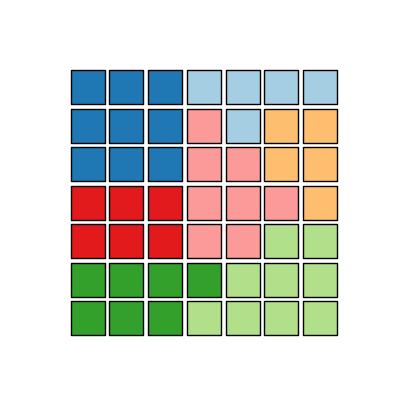

In [9]:
# colors = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'indigo',
#           4: 'blue', 5: 'violet', 6: 'cornflowerblue', 7: 'khaki', 8: 'gray',
#           9: 'olive', 10: 'steelblue'}

colors = {
0: "#a6cee3",
1: "#1f78b4",
2: "#b2df8a",
3: "#33a02c",
4: "#fb9a99",
5: "#e31a1c",
6: "#fdbf6f",
7: "#ff7f00",
8: "#cab2d6",
9: "#6a3d9a"
}

g = {(i): {(j,k) for j,k in groups[0] if solver.value(groups[i][j,k]) == 1} for i in groups}

plt.figure(figsize=(n-2,n-2))
plt.xlim(-2,n+1)
plt.ylim(-2,n+1)

for i in g:
    for j,k in g[i]:
        plt.scatter(k,n-j-1, marker= 's', s = (n-1)*100, c= colors[i], edgecolors= 'k')
        if solver.value(queens[j,k]) == 1:
            pass
            # plt.text(k-.3,n-j-1-.3, s = '\u2655', fontsize = 20, c = 'k', fontweight = 'heavy', zorder = 10)
        # plt.text(k,n-j-1, s = f'{j,k}')
plt.axis('off');

1


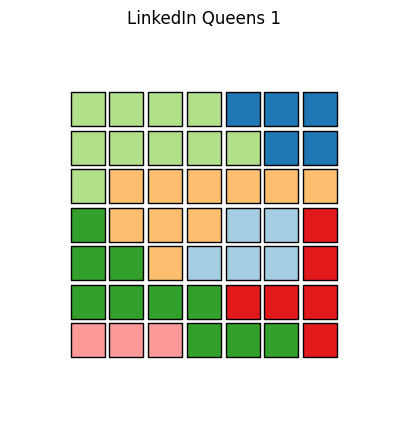

2


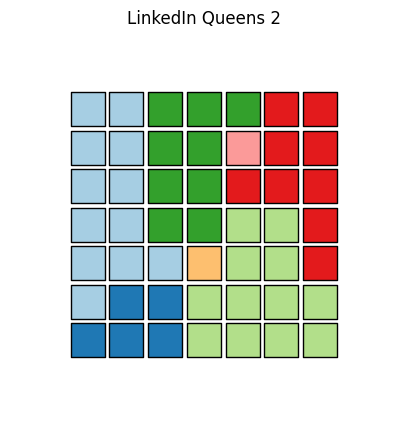

3


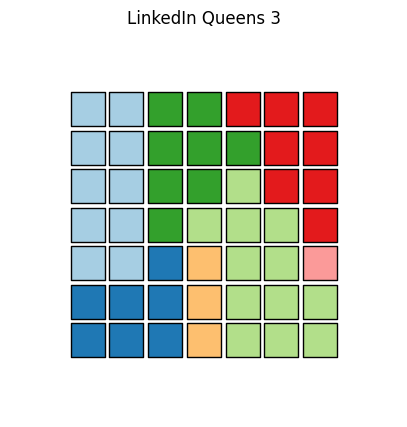

4


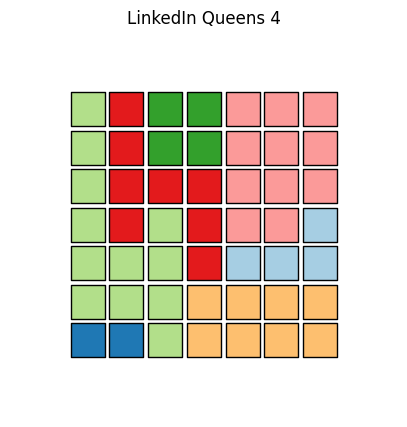

5


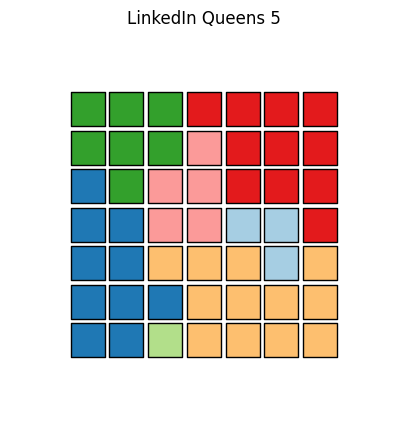

6


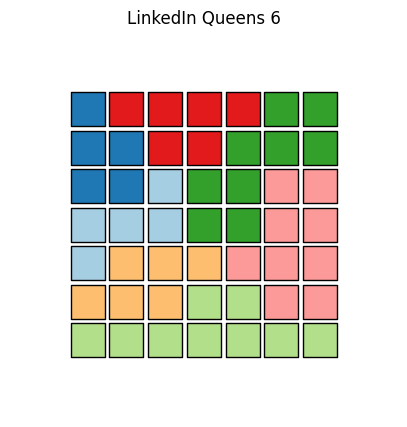

7


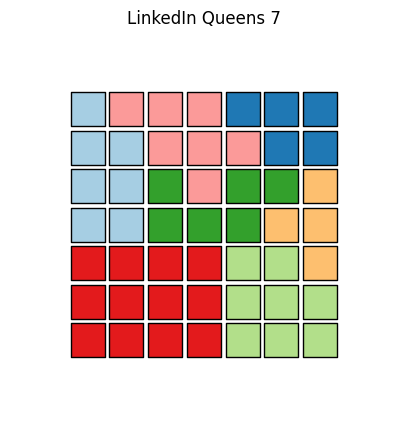

8


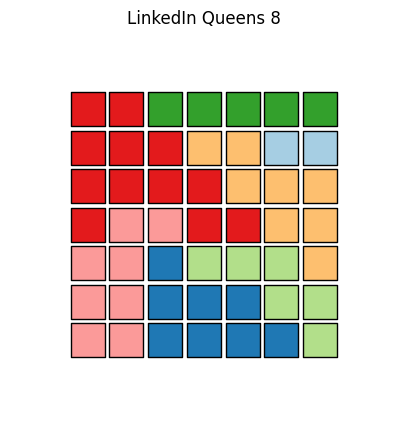

9


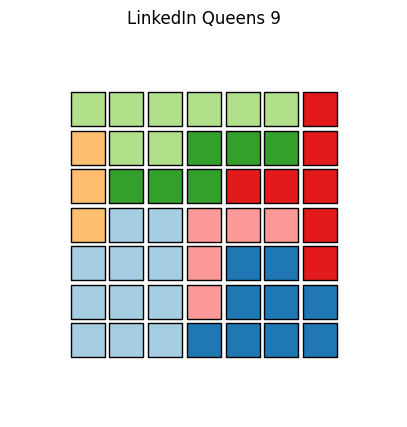

10


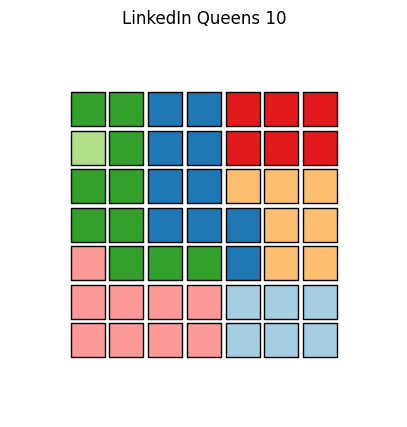

11


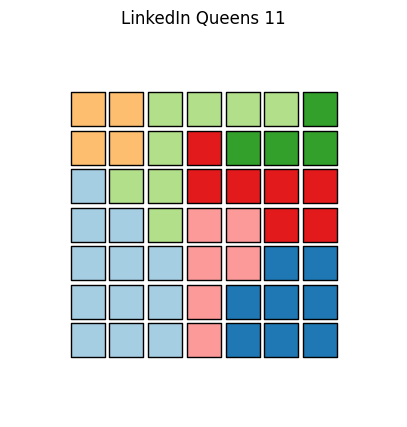

12


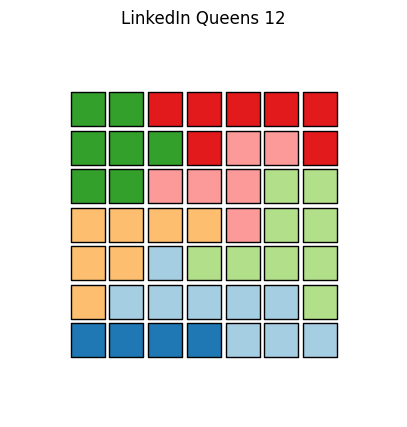

13


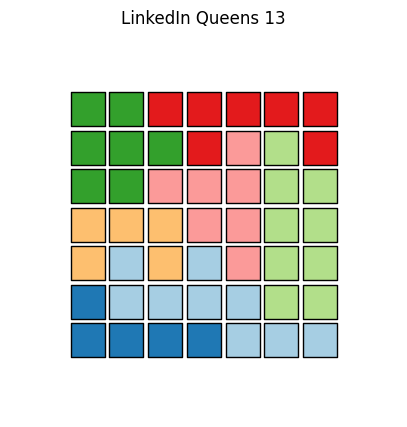

14


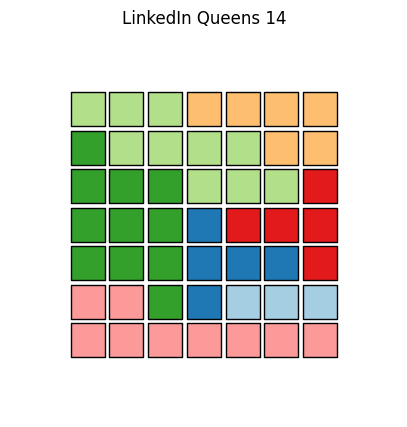

15


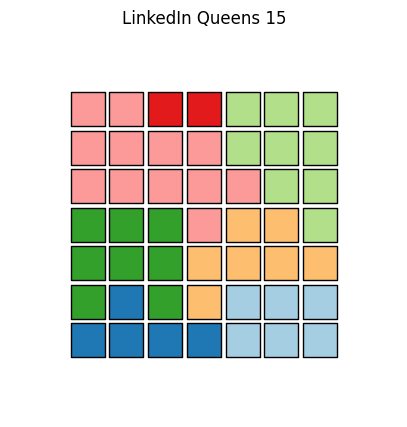

16


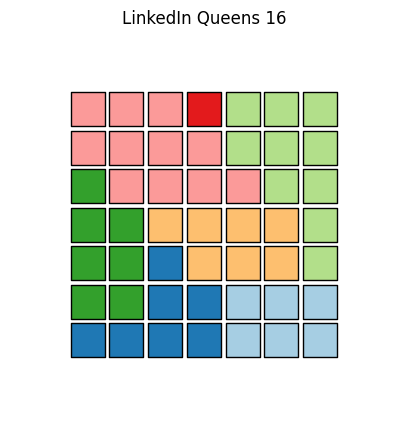

17


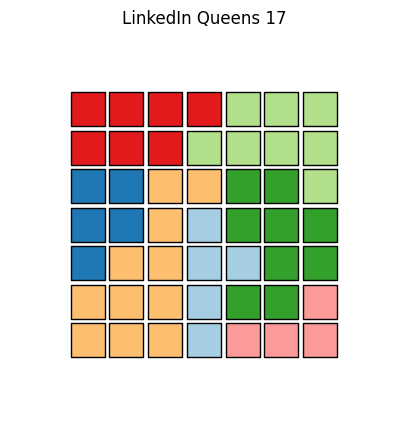

18


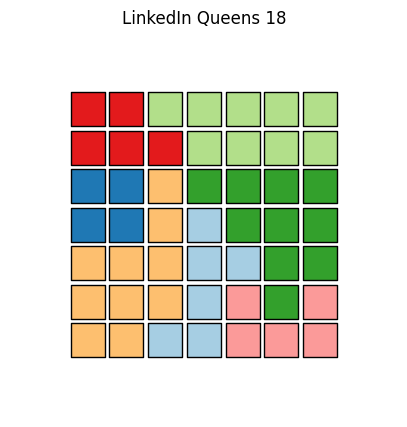

19


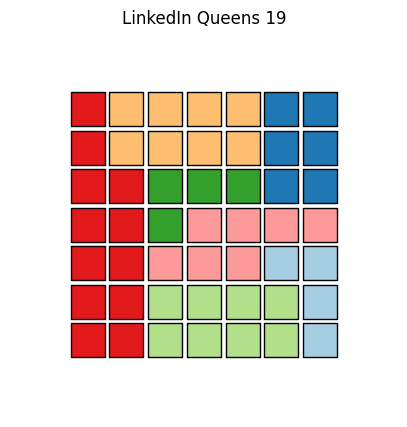

20


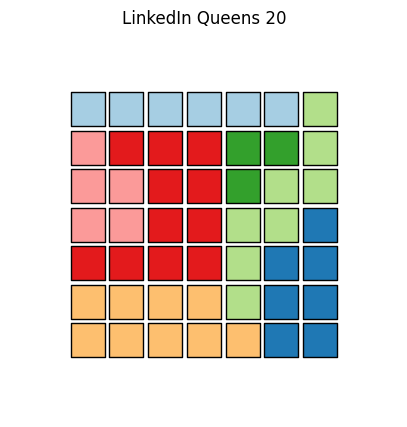

In [10]:
cntu = True
counter =0
limit = 20
while (cntu and counter < limit):
    A= [groups[i][j,k].Not() for i in groups for j,k in groups[i] if solver.value(groups[i][j,k])==1]
    B= [groups[i][j,k] for i in groups for j,k in groups[i] if solver.value(groups[i][j,k])==0]
    
    expr = A+B
    model.Add(sum(A + B) >= random.randint(n+3,n*2))
    status = solver.Solve(model)

    if status != cp_model.OPTIMAL:
        cntu = False
    else:
        counter+=1
        print(counter)
    
    g = {(i): {(j,k) for j,k in groups[0] if solver.value(groups[i][j,k]) == 1} for i in groups}

    plt.figure(figsize=(n-2,n-2))
    plt.xlim(-2,n+1)
    plt.ylim(-2,n+1)

    for i in g:
        for j,k in g[i]:
            plt.scatter(k,n-j-1, marker= 's', s = (n-1)*100, c= colors[i], edgecolors= 'k')
            if solver.value(queens[j,k]) == 1:
                pass
                # plt.text(k-.3,n-j-1-.3, s = '\u2655', fontsize = 20, c = 'k', fontweight = 'heavy', zorder = 10)
            # plt.text(k,n-j-1, s = f'{j,k}')
    plt.axis('off');
    plt.title(f'LinkedIn Queens {counter}')
    plt.show();